#  MongoDB Yelp Academic Dataset Analysis


In this project, we will be investigating how different database systems handle semi-structured JSON data. In particular, we will be placing emphasis on the use of MongoDB: a database system that stores data in a construct known as documents. We will be working with the **Yelp Academic Dataset** which contains a dataset of `businesses`, `reviews`, and `users`. Due to the limitations of JupyterHub and the Mongo instances we are working with, `reviews` and `users` are truncated to 7500 reviews and 1000 users. We will be using the full `businesses` dataset, however.

## Loading Up Mongo
We will be using Pymongo, a Python wrapper for MongoDB, for this project. After running the following cell, for the rest of the project, we can use the Python variables business, review, and user to access the corresponding collection.

In [2]:

import pandas as pd
import pymongo
from pymongo import TEXT
import numpy as np

myclient = pymongo.MongoClient("mongodb://localhost")
mydb = myclient["yelp"]
business = mydb["business"]
review = mydb["review"]
user = mydb["user"]

In [3]:
# UNCOMMENT: REMAKE  COLLECTIONS FROM SCRATCH. 

# review.drop()
# business.drop()
# user.drop()

## Loading Datasets
The following 2 cells will load the JSON datasets into the appropriate Mongo collections. 

In [4]:
import zipfile
import os.path

if not os.path.isfile('data/yelp_academic_dataset_review.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_review.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

if not os.path.isfile('data/yelp_academic_dataset_user.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_user.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

if not os.path.isfile('data/yelp_academic_dataset_business.json'):
    with zipfile.ZipFile('data/yelp_academic_dataset_business.json.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [5]:

import json

if business.count_documents({}) == 0:
    print("Loading business collection...")
    with open('data/yelp_academic_dataset_business.json', encoding='utf-8') as f:
        for line in f:
            business.insert_one(json.loads(line))

if review.count_documents({}) == 0:
    print("Loading review collection...")
    with open('data/yelp_academic_dataset_review.json', encoding='utf-8') as f:
        for line in f:
            review.insert_one(json.loads(line))
            
if user.count_documents({}) == 0:
    print("Loading user collection...")
    with open('data/yelp_academic_dataset_user.json', encoding='utf-8') as f:
        for line in f:
            user.insert_one(json.loads(line))

 `business`'s first document in it's collection.

In [80]:
business.find_one()

{'_id': ObjectId('6566758bfe41e029b0d75aab'),
 'business_id': '6iYb2HFDywm3zjuRg0shjw',
 'name': 'Oskar Blues Taproom',
 'address': '921 Pearl St',
 'city': 'Boulder',
 'state': 'CO',
 'postal_code': '80302',
 'latitude': 40.0175444,
 'longitude': -105.2833481,
 'stars': 4.0,
 'review_count': 86,
 'is_open': 1,
 'attributes': {'RestaurantsTableService': 'True',
  'WiFi': "u'free'",
  'BikeParking': 'True',
  'BusinessParking': "{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}",
  'BusinessAcceptsCreditCards': 'True',
  'RestaurantsReservations': 'False',
  'WheelchairAccessible': 'True',
  'Caters': 'True',
  'OutdoorSeating': 'True',
  'RestaurantsGoodForGroups': 'True',
  'HappyHour': 'True',
  'BusinessAcceptsBitcoin': 'False',
  'RestaurantsPriceRange2': '2',
  'Ambience': "{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': True}",
  'HasTV': 'Tr

## Part 1

# Finding the **Tuesday hours** for the restaurant named **Legal Sea Foods** at **100 Huntington Ave** in **Boston**. 

In [10]:
result_1a = list(business.find({'name': "Legal Sea Foods", 'address':'100 Huntington Ave','city':'Boston' }))[0]['hours']['Tuesday']
result_1a

'12:0-21:0'


# Writing a query that computes the average star rating for all businesses in Colorado with 30 reviews or greater.

In [13]:
list(business.find({"state": "CA"}).limit(3))

[{'_id': ObjectId('6566758bfe41e029b0d761c6'),
  'business_id': 'SNCRnaSy6E5fHgQuoCmmbQ',
  'name': 'Katia Photography',
  'address': '',
  'city': 'Portland',
  'state': 'CA',
  'postal_code': '97007',
  'latitude': 45.4501529,
  'longitude': -122.8849111,
  'stars': 5.0,
  'review_count': 11,
  'is_open': 1,
  'attributes': {'BusinessAcceptsBitcoin': 'False',
   'BusinessAcceptsCreditCards': 'True',
   'WiFi': "u'no'"},
  'categories': 'Shopping, Clothing Rental, Event Planning & Services, Fashion, Event Photography, Photographers, Session Photography',
  'hours': {'Monday': '8:0-22:0',
   'Tuesday': '8:0-22:0',
   'Wednesday': '8:0-22:0',
   'Thursday': '8:0-22:0',
   'Friday': '8:0-22:0',
   'Saturday': '8:0-22:0',
   'Sunday': '8:0-22:0'}},
 {'_id': ObjectId('65667594fe41e029b0d7d232'),
  'business_id': 'cjwnQMQOGOYgB5uNmiYWLA',
  'name': 'Verizon Authorized Retailer - GoWireless',
  'address': '4655 SW Griffith Dr, Ste 125',
  'city': 'Beaverton',
  'state': 'CA',
  'postal_code'

In [14]:
result_1b = list(business.aggregate([{"$match":{"review_count": {"$gte": 30}}}
                                     ,{"$match":{"latitude": {"$gte": 37, "$lte": 41}}}
                                     ,{"$match":{"longitude": {"$gte": -109, "$lte": -102}}}
                                     ,{"$group":{"_id":{}, 'averageStars': {"$avg":"$stars"}}}]))[0]['averageStars']
result_1b

3.6735412474849096

# Creating an aggregation pipeline to find the town in each state with the highest average number of stars.
 **considering towns with greater than or equal to 5 reviews in total across all the restaurants in that town so that the average is meaningful.** output contains exactly two fields:
- `averageStars` which contains the average number of stars for the corresponding town.
- `city_state` which is the name of the town with the highest value of average stars in the state concatenated with a comma followed by the state initials

In [17]:
result_1c_pipeline = [
    {'$group': {
            '_id': {'city': '$city', 'state': '$state'},
            'totalReviews': {'$sum': '$review_count'},
            'averageStars': {'$avg': '$stars'}}},
    {'$match': {
            'totalReviews': {'$gte': 5} }},
    {'$sort': {'_id.state': 1, 'averageStars': -1}},
    {'$group': {
            '_id': '$_id.state',
            'city': {'$first': '$_id.city'},
            'averageStars': {'$first': '$averageStars'} }},
    {'$project': {
            '_id': 0,
            'city_state': {'$concat': ['$city', ', ', '$_id']},
            'averageStars': 1} }]

result_1c = list(business.aggregate(result_1c_pipeline))
result_1c

[{'averageStars': 3.5, 'city_state': 'Austin, MN'},
 {'averageStars': 3.5, 'city_state': 'North Reading, ME'},
 {'averageStars': 5.0, 'city_state': 'lake mary, FL'},
 {'averageStars': 4.5, 'city_state': 'Salem, AZ'},
 {'averageStars': 1.5, 'city_state': 'Sheridan, WY'},
 {'averageStars': 5.0, 'city_state': 'Vancovuer, BC'},
 {'averageStars': 5.0, 'city_state': 'Spring Valley, NY'},
 {'averageStars': 5.0, 'city_state': 'Irvine, CA'},
 {'averageStars': 2.0, 'city_state': 'Ellsworth, KS'},
 {'averageStars': 5.0, 'city_state': 'Vancover, WA'},
 {'averageStars': 3.5, 'city_state': 'Norfolk, VA'},
 {'averageStars': 5.0, 'city_state': 'Porltand, OR'},
 {'averageStars': 4.5, 'city_state': 'Vancouver, ABE'},
 {'averageStars': 2.5, 'city_state': 'Sanford, NC'},
 {'averageStars': 4.0, 'city_state': 'Hampton, NH'},
 {'averageStars': 3.5, 'city_state': 'Rio Rancho, NM'},
 {'averageStars': 5.0, 'city_state': 'PICKERINGTON, OH'},
 {'averageStars': 5.0, 'city_state': 'Vancouver, DC'},
 {'averageStars'

# Doing a sentiment analysis and find all the restaurants we should avoid! 
Writing a query to find all the reviews with "disgusting", "horrible", "horrid", "gross", "bad", or "hate". 

In [20]:

if 'text_text' not in review.index_information():
    review.create_index([('text', TEXT)])

result_1d = review.count_documents({
    '$text': {
        '$search': "disgusting horrible horrid gross bad hate"}})

result_1d

728

# Creating a new collection called `review_boolean` 
which is the exact same as `reviews` EXCEPT there is a new field called `to_avoid` which is the string "true"  if the review `text` contains the words "disgusting", "horrid", "horrible", "gross", "bad", or "hate" and the string "false" if not.  

In [23]:
review_boolean = mydb["review_boolean"]
review_boolean.drop()


if 'text_text' not in review_boolean.index_information():
    review_boolean.create_index([('text', TEXT)])

all_reviews = list(review.find({}))
review_boolean.insert_many(all_reviews)

review_boolean.update_many(
    {'$text': {
            '$search': "disgusting horrid horrible gross bad hate"}},
    {'$set': {'to_avoid': 'true'}})

review_boolean.update_many({'to_avoid': {'$exists': False}},
    {'$set': {'to_avoid': 'false'}})

In [24]:
review_boolean = mydb["review_boolean"]
review_boolean.find_one()

{'_id': ObjectId('656675b8fe41e029b0d9cdf4'),
 'review_id': 'lWC-xP3rd6obsecCYsGZRg',
 'user_id': 'ak0TdVmGKo4pwqdJSTLwWw',
 'business_id': 'buF9druCkbuXLX526sGELQ',
 'stars': 4.0,
 'useful': 3,
 'funny': 1,
 'cool': 1,
 'text': "Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle 

# Analysis of removing the `to_avoid` field from the `review_boolean` collection. 
Calculating the `difference` between the data size of `review_boolean` with the `to_avoid` field and without it. 

In [27]:
with_avoid = mydb.command("collstats", "review_boolean")['size']

review_boolean.update_many({}, {'$unset': {'to_avoid': ""}})

without_avoid = mydb.command("collstats", "review_boolean")['size']
difference = with_avoid - without_avoid
difference

149272



<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Part 2


# Exporting the MongoDB collections into Pandas DF using a function called `json_normalize`.
 We truncated `business` to meet the memory constraints set by Jupyter. The variable `business_trunc` contains the reference the truncated business collection.

In [44]:
business_trunc = mydb["business_trunc"]
count = 0
if business_trunc.count_documents({}) != 1000:
    for document in business.find({}):
        count += 1
        business_trunc.insert_one(document)
        if count == 1000:
            break

business_cursor = business_trunc.find({})
review_cursor = mydb["reviews"].find({})
user_cursor = mydb["users"].find({})

# Loading the collections into Pandas. 
from pandas import json_normalize
user_df = json_normalize(user_cursor)
review_df = json_normalize(review_cursor)
business_df = json_normalize(business_cursor)

# Performing a inner join on `business_df` with itself on `stars`. 
The final dataframe is be saved to a variable called `result_2b` and contains 3 columns in this particular order: the name of the first restaurant, the name of the second restaurant, and the number of the stars.


In [46]:
joined_df = business_df.merge(business_df, on='stars')
result_2b = joined_df[['name_x', 'name_y', 'stars']]
result_2b.columns = ['first', 'second', 'stars']
result_2b

,first,second,stars
0,Oskar Blues Taproom,Oskar Blues Taproom,4.0
1,Oskar Blues Taproom,Flying Elephants at PDX,4.0
2,Oskar Blues Taproom,Crossfit Terminus,4.0
3,Oskar Blues Taproom,Capital City Barber Shop,4.0
4,Oskar Blues Taproom,Star Kreations Salon and Spa,4.0
...,...,...,...
153959,White Egret Farm,Bluffs at Town Lake,1.5
153960,White Egret Farm,Taco Cabana,1.5
153961,White Egret Farm,Shaws,1.5
153962,White Egret Farm,Steak ’n Shake,1.5


# Constructing a dataframe `missing_value_df` with two columns: `column_name` and `percent_missing`.
 `percent_missing` is the percentage of NaN values in the corresponding column in `business_df`.


In [49]:
percent_missing = business_df.isnull().sum() * 100 / len(business_df)
missing_value_df = pd.DataFrame({'column_name': business_df.columns,'percent_missing': percent_missing})
missing_value_df.head()

,column_name,percent_missing
_id,_id,0.0
business_id,business_id,0.0
name,name,0.0
address,address,0.0
city,city,0.0


# Plotting a histogram distribution of the percentage of NaN values across all columns (via Pandas function). 

<Axes: >

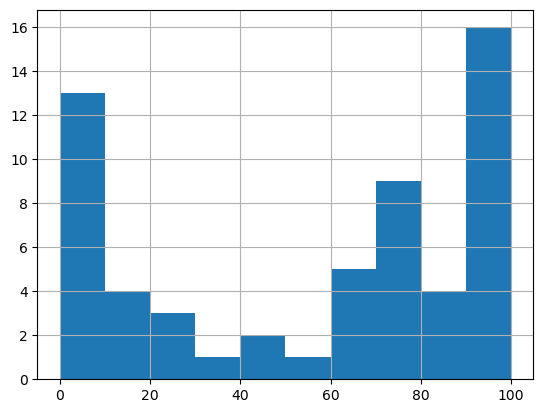

In [52]:
percent_missing = business_df.isnull().sum() * 100 / len(business_df)
percent_missing.hist()

Columns that are 90%+ NaN: 16

 # Altering `business_df` to exclude the columns with more than 80%+ null values 
 (keeping columns with 80% null values or less). 

In [55]:
percent_missing = business_df.isnull().sum() * 100 / len(business_df)
columns_to_keep = percent_missing[percent_missing <= 80].index
important_attribute_business_df = business_df[columns_to_keep]
important_attribute_business_df.head()

,_id,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.GoodForKids,attributes.ByAppointmentOnly
0,6566758bfe41e029b0d75aab,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,...,None,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,NaN,NaN
1,6566758bfe41e029b0d75aac,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,...,False,5:0-18:0,5:0-17:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,True,False
2,6566758bfe41e029b0d75aad,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,...,NaN,NaN,NaN,NaN,11:0-18:0,11:0-18:0,11:0-18:0,11:0-18:0,NaN,False
3,6566758bfe41e029b0d75aae,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
4,6566758bfe41e029b0d75aaf,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,...,NaN,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,16:0-19:0,9:0-11:0,NaN,False,NaN


<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Part 3

Scenario: Imagine you are in charge of managing your family reunion. You would like to book a private room at a restaurant.
However, you would also like to optimize for chaos. You notice that there is an attribute called `RestaurantsGoodForGroups`. We write a query that returns all restaurants that **do not** have the `RestaurantsGoodForGroups` attribute so that the trajectory of the reunion is determined by fate

In [64]:
# The following text index may be useful!
if 'categories_text' not in business.index_information():
    business.create_index([('categories', TEXT)])

query = {'categories': {'$regex': 'Restaurants'},'attributes.RestaurantsGoodForGroups': {'$exists': False}}
results_3a_str = business.count_documents(query)


NEXT your relatives inform you that they would like to be at the restaurant when it opens to beat the crowds. Furthermore, after sending
a when2meet, most of your relatives would prefer for the meal to be on a Friday and the start time of the meal to be 
between 5-6:59PM (17:00-18:59). 

# Finding the number of restaurants that open on Fridays between 17:00-18:59 


In [87]:
pipeline = [
    {'$match': {
            'categories': {'$regex': 'Restaurant'},
            'hours.Friday': {'$exists': True, '$ne': None}}},
    {'$addFields': {
            'friday_hours': {
                '$split': ['$hours.Friday', '-']}}},
    {'$match': {
            'friday_hours': {'$ne': []},
            '$expr': {
                '$and': [
                    {'$gte': [{'$toInt': {'$arrayElemAt': [{'$split': [{'$arrayElemAt': ['$friday_hours', 0]}, ':']}, 0]}}, 17]},
                    {'$lt': [{'$toInt': {'$arrayElemAt': [{'$split': [{'$arrayElemAt': ['$friday_hours', 0]}, ':']}, 0]}}, 19]}]}}}]

count = business.aggregate(pipeline)
results_3b_str = len(list(count))



NEXT Some members of your family are vegetarian so you would like to only eat at restaurants with the Vegetarian category. 
However, the `categories` are stored as a single string! You would like to make it easy to access Vegetarian as a separate field. 

# Writing a query that does the following: for every category in `categories`, add a new document that contains the `ObjectId` for the previous document (labeled `_id`), the name of the business (labeled `name`), and the category (labeled `category`).

In [121]:
results_3c_pipeline = [
    {'$match': {
            '$text': {'$search': "Restaurants"}}},
    {'$addFields': {
            'category_array': {'$split': ['$categories', ', ']}}},
    {'$unwind': '$category_array'},
    {'$project': {
            '_id': 1,
            'name': 1,
            'category': '$category_array'}},
    {'$sort': {'name': 1, 'category': 1}}]

result_3c = list(business.aggregate(q4c_pipeline))

In [122]:
result_3c[:5]

[{'_id': ObjectId('6566758ffe41e029b0d790c2'),
  'name': " Gruby's New York Deli",
  'category': 'Caterers'},
 {'_id': ObjectId('6566758ffe41e029b0d790c2'),
  'name': " Gruby's New York Deli",
  'category': 'Delis'},
 {'_id': ObjectId('6566758ffe41e029b0d790c2'),
  'name': " Gruby's New York Deli",
  'category': 'Event Planning & Services'},
 {'_id': ObjectId('6566758ffe41e029b0d790c2'),
  'name': " Gruby's New York Deli",
  'category': 'Kosher'},
 {'_id': ObjectId('6566758ffe41e029b0d790c2'),
  'name': " Gruby's New York Deli",
  'category': 'Restaurants'}]


This change in representation has made it super easy to view all the vegetarian restaurants and count them without the use of an index since we can now simply filter by whether or not 'Vegetarian' is a field in our document!

In [125]:
results_3d_pipeline = results_3c_pipeline[:]
results_3d_pipeline.append({"$match": {"category": 'Vegetarian'}})
result_3d = list(business.aggregate(q4d_pipeline))



#vegetarian restaurants count = 1482